# 0.0 Imports

In [119]:
import pandas as pd
import inflection
import math
import seaborn as sns
import numpy as np 
import matplotlib
from matplotlib import pyplot as plt
import datetime
from tabulate import tabulate
from scipy import stats as ss

## 0.1 Helper Functions

In [54]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [17, 10]
    sns.set()
jupyter_settings()

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k  = cm.shape
    chi2 = ss.chi2_contingency(cm) [0]
    chi2corr = max (0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr= r-(r-1)**2/(n-1)
    return np.sqrt ((chi2/n) / (min(k -1, r-1))) 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/andressasantos/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading data


In [55]:
df_sales_raw = pd.read_csv('/home/andressasantos/Documents/comunidade_ds/ds_producao/data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('/home/andressasantos/Documents/comunidade_ds/ds_producao/data/store.csv', low_memory = False)


#merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store' )



# 1.0 Descricao dos dados

In [56]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [57]:
cols_old= ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
           'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = list (map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions 

In [58]:
print('number of Rows: {}'. format (df1.shape[0]))
print('number of Collumns: {}'. format (df1.shape[1]))


number of Rows: 1017209
number of Collumns: 18


## 1.3 Data Types

In [59]:
df1['date']= pd.to_datetime (df1['date'])


## 1.4 Check NA

In [60]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [61]:
df1['competition_distance'].max()

75860.0

In [62]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 200000 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

#competition_open_since_year  

df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1) 

                            
#promo2_since_week    
df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year  

df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


#promo_interval   
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10: 'Oct', 11: 'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo']  = df1[['promo_interval','month_map']].apply (lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                              if x['month_map'] in x['promo_interval']. split (',') else 0, axis=1)

In [63]:
df1.sample(8).T.reset_index()

,index,789562,632183,630653,911745,179188,210843,885300,715851
0,store,928,764,349,461,789,109,776,807
1,day_of_week,3,4,5,5,6,5,1,6
2,date,2013-07-24 00:00:00,2013-12-12 00:00:00,2013-12-13 00:00:00,2013-04-05 00:00:00,2015-02-21 00:00:00,2015-01-23 00:00:00,2013-04-29 00:00:00,2013-09-28 00:00:00
3,sales,5285,4110,7809,5322,2801,5804,6465,9993
4,customers,528,432,843,552,336,697,646,961
5,open,1,1,1,1,1,1,1,1
6,promo,0,0,0,0,0,0,1,0
7,state_holiday,0,0,0,0,0,0,0,0
8,school_holiday,1,0,0,1,0,0,0,0
9,store_type,d,a,c,d,a,a,c,a


## 1.6 Changes Types

In [64]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


In [65]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical 

In [106]:

num_attributes = df1.select_dtypes (include = ['int64', 'float64'])

cat_attributes = df1.select_dtypes (exclude = ['int64', 'float64', 'datetime64[ns]'])

### Numerical Atributes Statistical

In [67]:
# Central Tendency - means, median
ct1 = pd.DataFrame(num_attributes.apply (np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply (np.median)).T

# Dispersion - std, min, max, range, skev, kurtosis

d1 = pd.DataFrame(num_attributes.apply (np.std)).T
d2 = pd.DataFrame(num_attributes.apply (min)).T
d3 = pd.DataFrame(num_attributes.apply (max)).T
d4 = pd.DataFrame(num_attributes.apply (lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply (lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply (lambda x: x.kurtosis() )).T

#concatenate
#m = pd.concat ([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
#m.columns = ['attributes','min','max','range','mean','median', 'std', 'skew', 'kurtosis'] 

In [68]:
m = num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T.reset_index()

In [69]:
m.sample(6)

,index,mean,median,std,min,max,skew,kurtosis
12,promo2_since_year,2012.793297,2013.0,1.662658,2009.0,2015.0,-0.784436,-0.210075
13,is_promo,0.161100,0.0,0.367623,0.0,1.0,1.843742,1.399388
10,promo2,0.500564,1.0,0.500000,0.0,1.0,-0.002255,-1.999999
9,competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304
3,customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154


/home/andressasantos/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

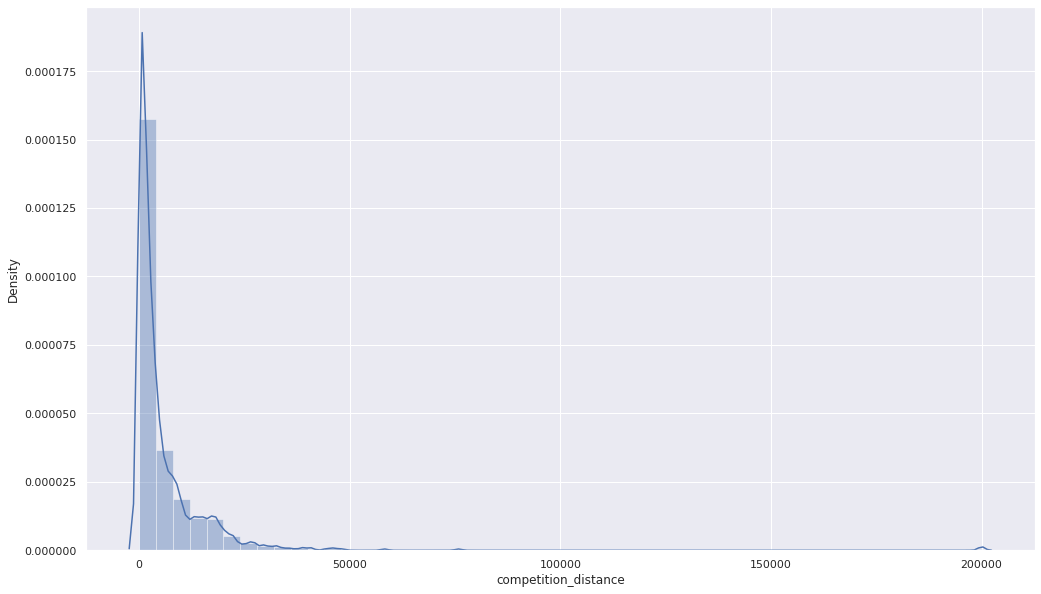

In [70]:
sns.distplot( df1['competition_distance'])

### Categorical Attributes

In [71]:
cat_attributes.apply (lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

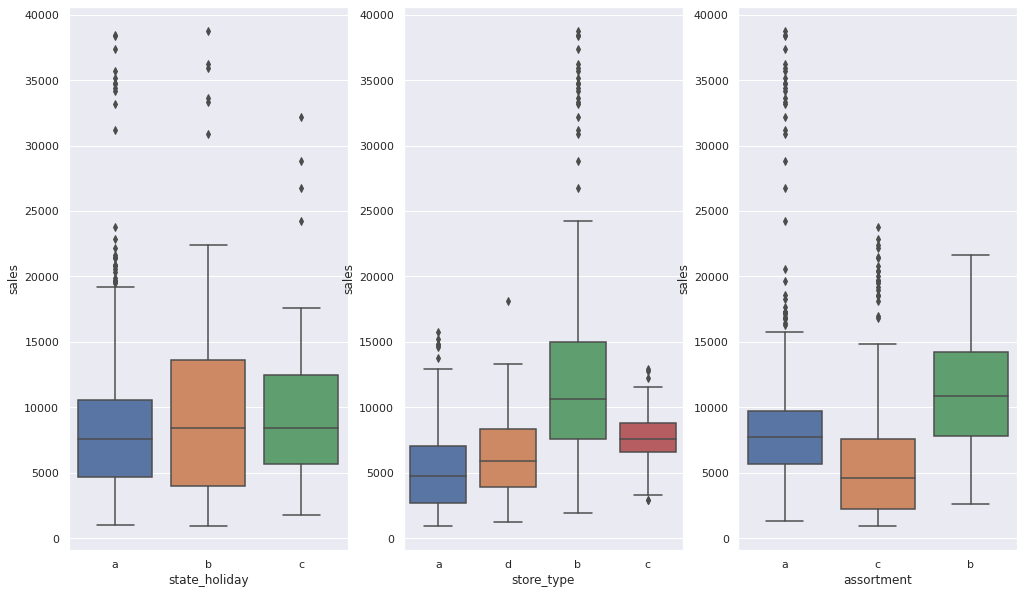

In [72]:
aux1 = df1 [(df1['state_holiday']!='0') & (df1['sales'] > 0)]
plt.subplot(1, 3, 1)

sns.boxplot(x='state_holiday', y='sales', data= aux1)

plt.subplot(1, 3, 2)

sns.boxplot(x='store_type', y='sales', data= aux1)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data= aux1)

# 2.0 Feature Engineering

In [73]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipoteses

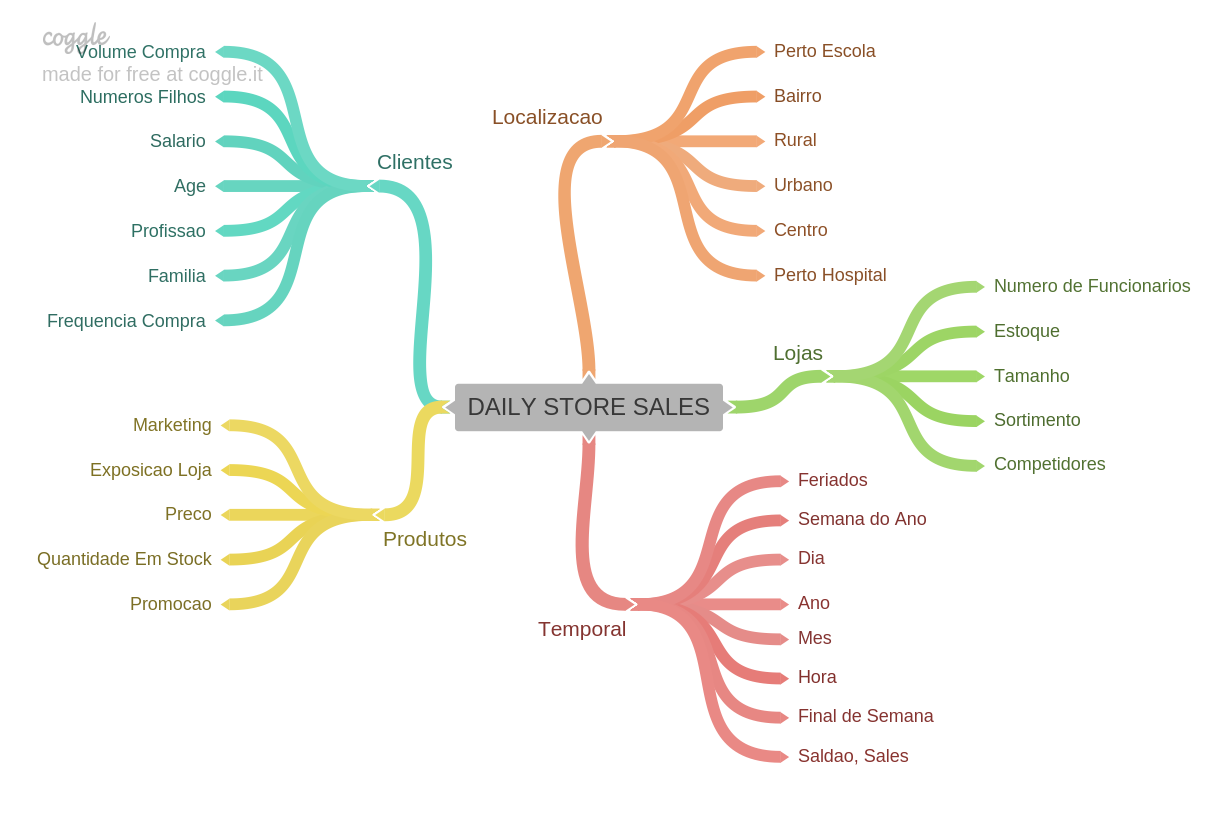

## 2.2 Criacao das Hipoteses

###  2.2.1 Hipoteses Loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipoteses do Produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Hipoteses Final

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [74]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#competition_since
df2['competition_since'] = df2.apply (lambda x: datetime.datetime (year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis = 1)
df2['competition_time_month'] = (((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int))

#promo_since
df2 ['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2 ['promo_since'].apply (lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta (days = 7))

df2['promo_time_week'] = (((df2['date'] - df2['promo_since'])/7). apply (lambda x: x.days).astype(int))

#assortment
df2['assortment'] = df2['assortment'].apply (lambda x: 'basic'if x== 'a' else 'extra' if x== 'b' else 'extended')


#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply (lambda x: 'public_holiday'if x== 'a' else 'easter_holiday' if x== 'b' else 'christmas'if x== 'c' else 'regular_day')



/tmp/ipykernel_29952/196971261.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [75]:
df2.head().T.reset_index()

,index,0,1,2,3,4
0,store,1,2,3,4,5
1,day_of_week,5,5,5,5,5
2,date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
3,sales,5263,6064,8314,13995,4822
4,customers,555,625,821,1498,559
5,open,1,1,1,1,1
6,promo,1,1,1,1,1
7,state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
8,school_holiday,1,1,1,1,1
9,store_type,c,a,a,c,a


# 3.0 Filtragem de Variaveis

In [76]:
df3 = df2.copy()

In [77]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [78]:
df3 = df3 [(df3['open'] !=0 ) & (df3 ['sales'] >0)]

## 3.2 Filtragem das colunas

In [79]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop (cols_drop, axis=1)

In [80]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Analise Exploratoria dos dados

In [81]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response variables

/home/andressasantos/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


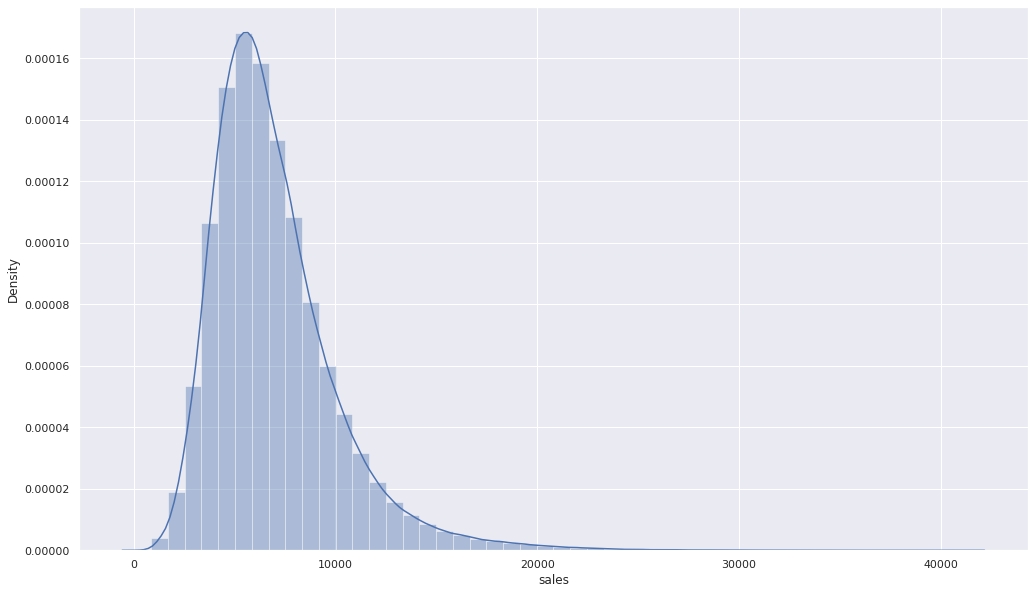

In [82]:
sns.distplot(df4['sales']);

### 4.1.2 Numerical variables

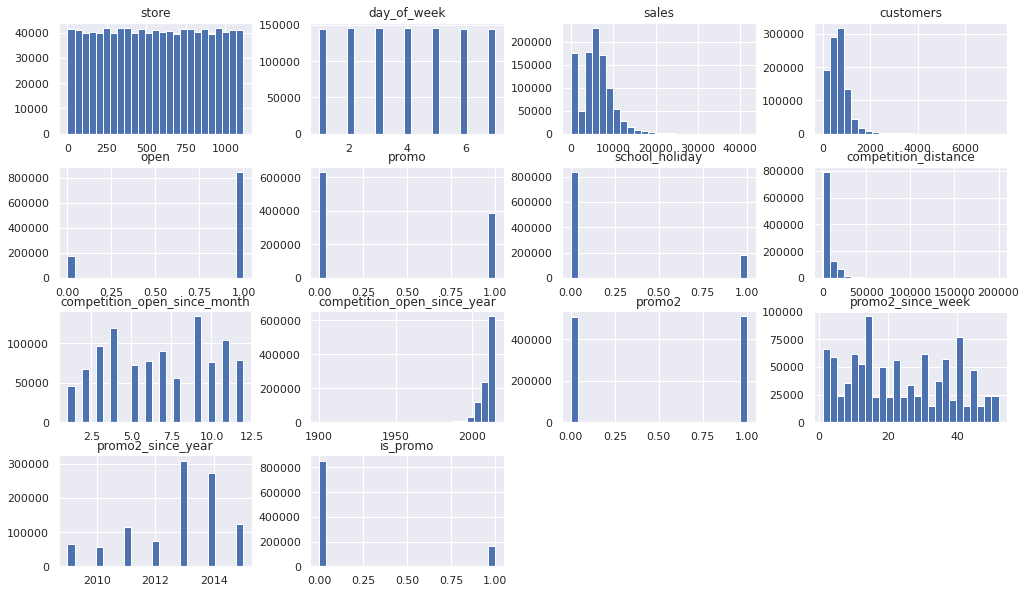

In [83]:
num_attributes.hist(bins = 25);

### 4.1.3 Categorical variables

/home/andressasantos/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/andressasantos/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/andressasantos/.pyenv/versions/3.8.1/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument w

<AxesSubplot:xlabel='sales', ylabel='Density'>

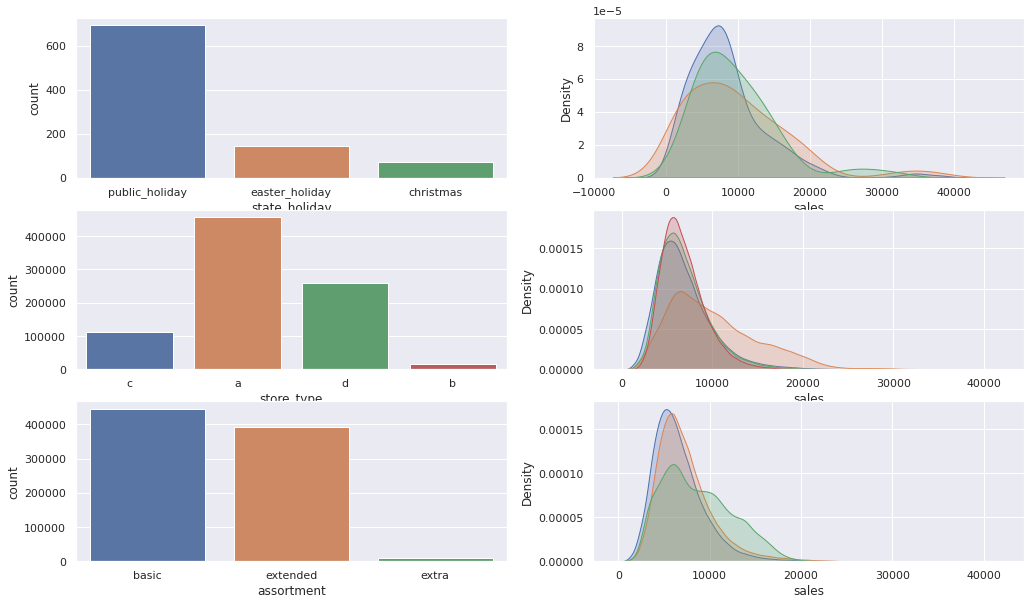

In [84]:
#state_holiday

plt.subplot(3,2,1,);
a= df4 [df4['state_holiday'] != 'regular_day']
sns.countplot (a ['state_holiday'])

plt.subplot(3,2,2,);
sns. kdeplot (df4 [df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)

sns. kdeplot (df4 [df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)

sns. kdeplot (df4 [df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)


#store_type
plt.subplot(3,2,3,);

sns.countplot (df4 ['store_type'])

plt.subplot(3,2,4);
sns. kdeplot (df4 [df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns. kdeplot (df4 [df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns. kdeplot (df4 [df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns. kdeplot (df4 [df4['store_type'] == 'd']['sales'], label = 'd', shade=True)

#assortment

plt.subplot(3,2,5,);
sns.countplot (df4 ['assortment'])

plt.subplot(3,2,6);
sns. kdeplot (df4 [df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns. kdeplot (df4 [df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns. kdeplot (df4 [df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)



## 4.2 Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

#FALSA: Lojas com maior(extra) sortimentos vedem menos (insight/ dois tipos de comportamento )


<AxesSubplot:xlabel='year_week'>

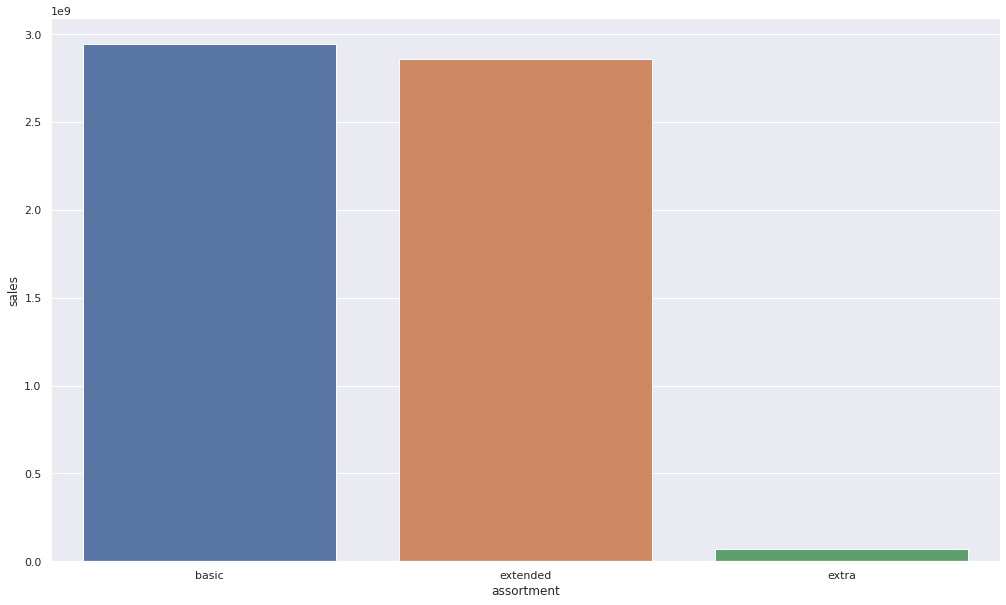

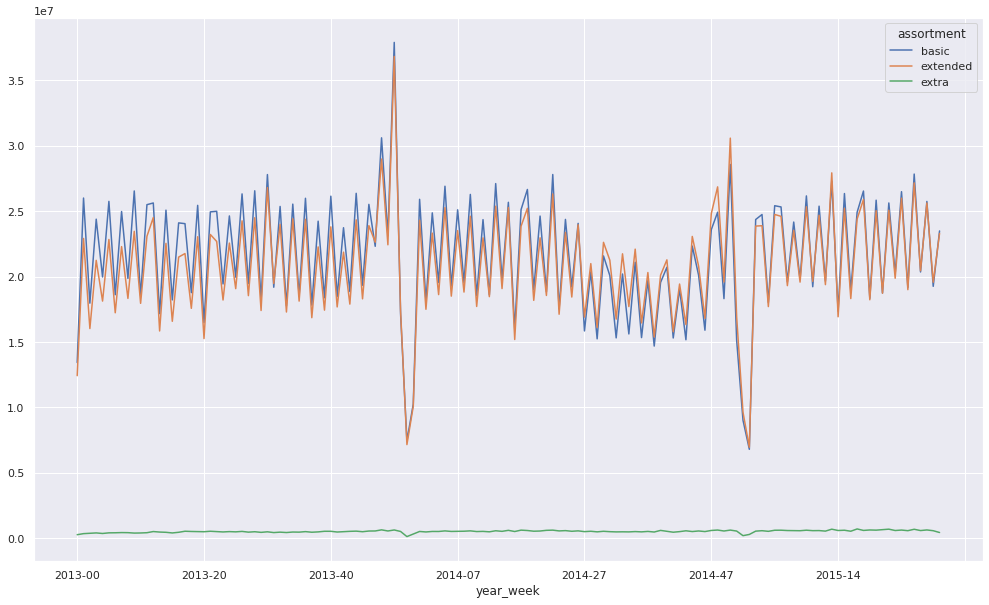

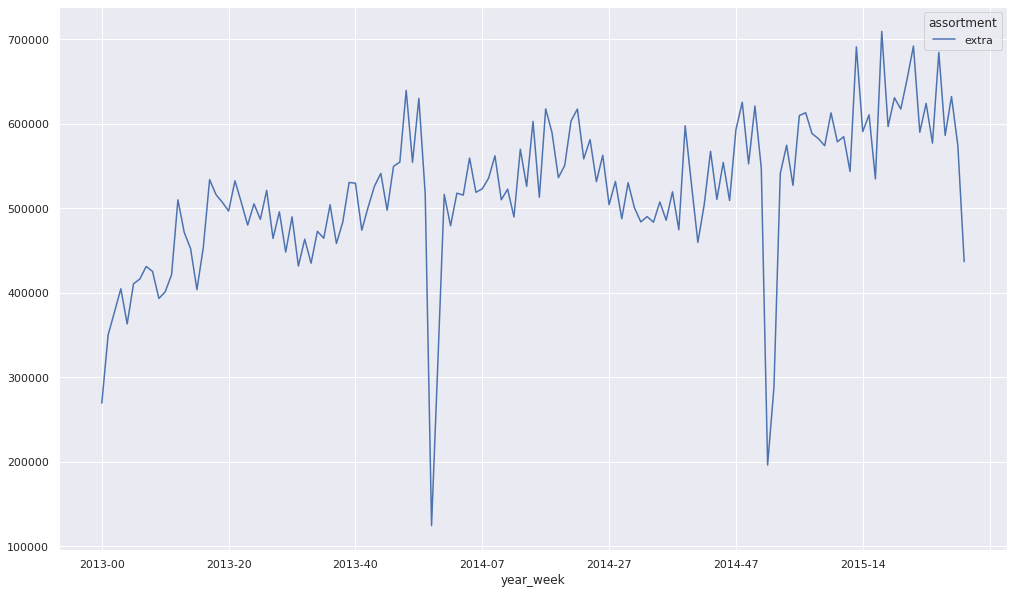

In [85]:
aux1 = df4[['assortment', 'sales']].groupby ('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales',data=aux1);


aux2 = df4[['year_week','assortment', 'sales']].groupby (['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values ='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values ='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.

#Falsa: Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.(insight)

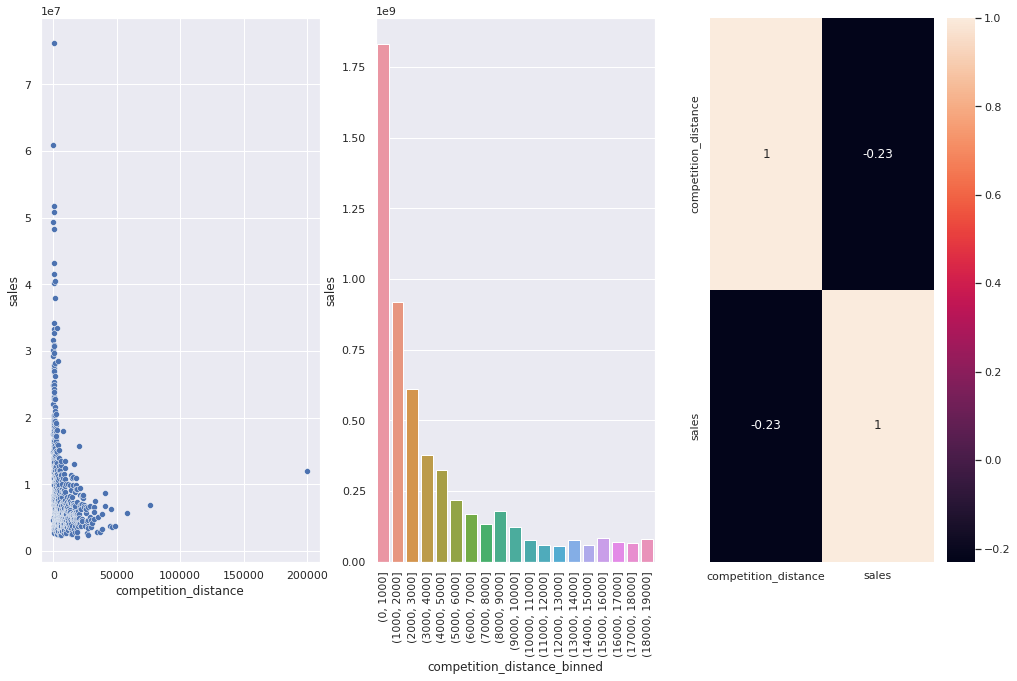

In [86]:
aux1 = df4[['competition_distance', 'sales']].groupby ('competition_distance').sum().reset_index()


plt.subplot(1,3,1)
sns.scatterplot (x = 'competition_distance', y = 'sales', data=aux1);

plt.subplot(1,3,2)
bins = list (np.arange(0,20000,1000))
aux1['competition_distance_binned']  = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby ('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y= 'sales', data=aux2);
plt.xticks (rotation = 90 )

#coleção fraca
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

In [87]:
aux1.sample(5)

,competition_distance,sales,competition_distance_binned
376,5800.0,5660528,"(5000, 6000]"
569,17290.0,3668097,"(17000, 18000]"
242,2970.0,5649774,"(2000, 3000]"
174,1990.0,4810209,"(1000, 2000]"
52,540.0,30697646,"(0, 1000]"


### H3. Lojas com competidores à mais tempo deveriam vendem mais.
#Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

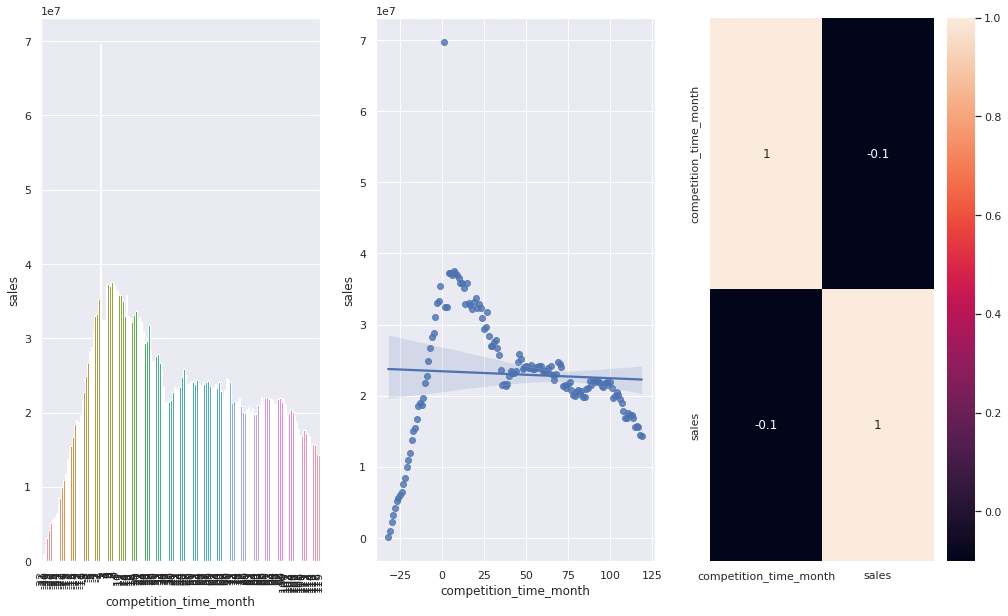

In [88]:
plt.subplot(1,3,1)
aux1= (df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index())
aux2 = aux1 [(aux1['competition_time_month'] <120) & (aux1['competition_time_month'] !=0)]
plt.xticks (rotation = 90 )
sns.barplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,2)
sns.regplot (x='competition_time_month', y='sales', data=aux2)

#corelação fraca
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

#Falsa:Lojas com promoções ativas pos mais tempo vandem menos, depois de um certo periodo de promoções


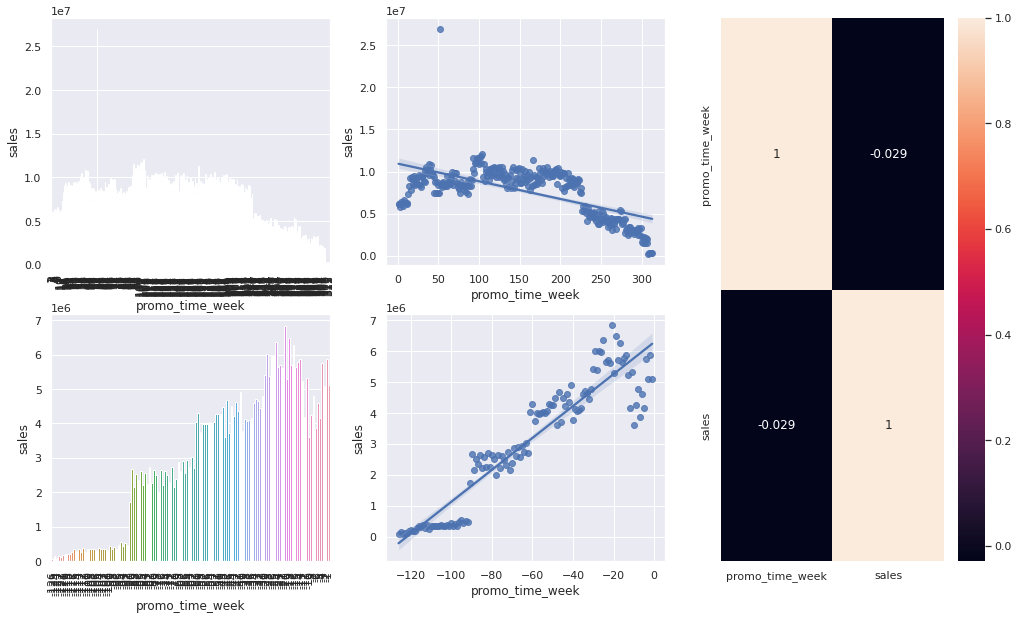

In [89]:
aux1 = (df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index())

grid = GridSpec(2,3)


plt.subplot(grid[0,0])
aux2 = aux1 [aux1['promo_time_week'] >0] #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks (rotation = 90 );


plt.subplot(grid[0,1])
sns.regplot (x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1 [aux1['promo_time_week'] < 0 ] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks (rotation = 90 );


plt.subplot(grid[1,1])
sns.regplot (x='promo_time_week', y='sales', data=aux3);


#corelacao muito fraca
plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);




### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s

  

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
#Falsa: Lojas com mais promoções consecutivas vedem menos.(insight)

In [90]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


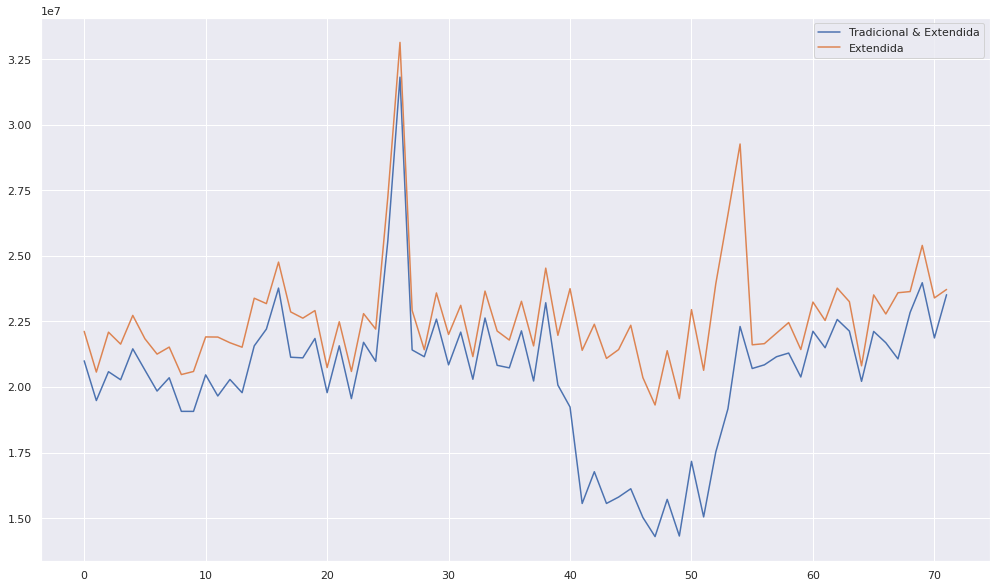

In [91]:
aux1 = df4 [(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()


aux2 = df4 [(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend (labels = ['Tradicional & Extendida', 'Extendida']) 
#revelancia para o modelo pequena


### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
#FALSA Lojas abertas durante o feriado do Natal vendem menos.


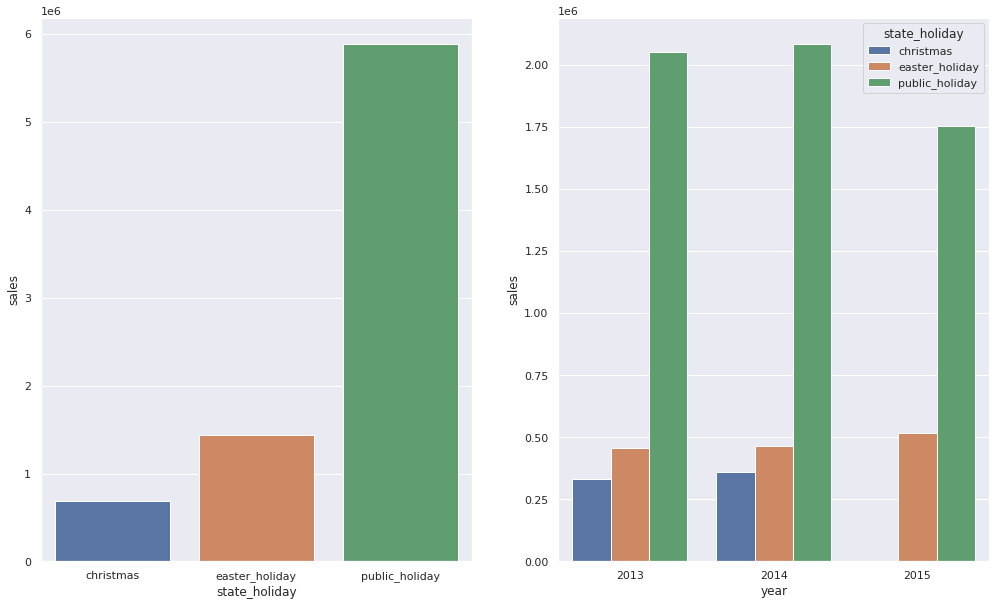

In [92]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );
#revelante para o modelo

### H8. Lojas deveriam vender mais ao longo dos anos.
#Falsa lojas vedem menos ao longo dos anos


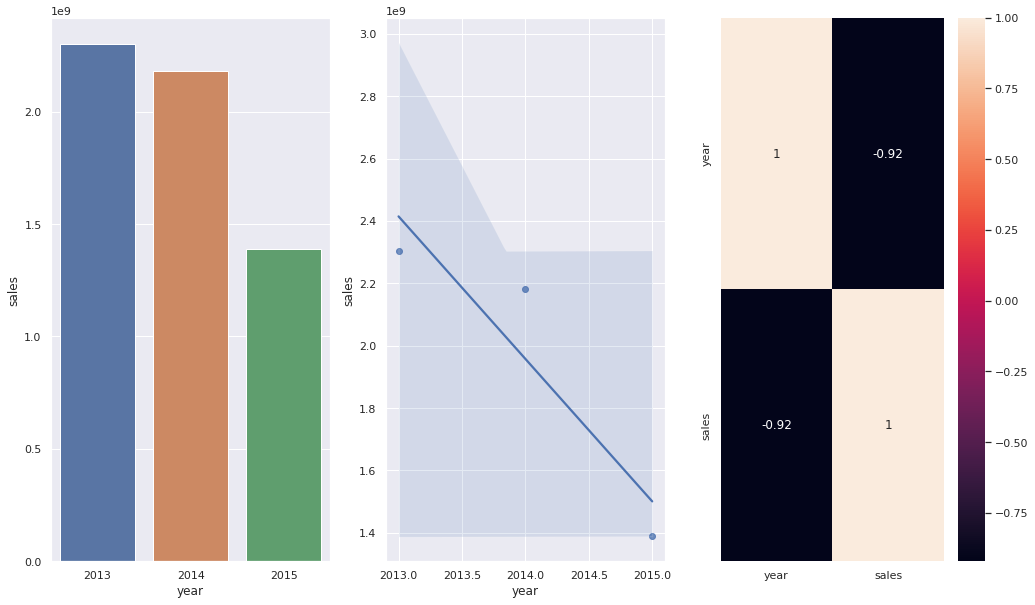

In [93]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

#tendencia
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );
#corelacao muito forte(ano aberto)
plt.subplot( 1, 3, 3 )
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
#Falsa:Lojas vedem menos no segunda semestre do ano


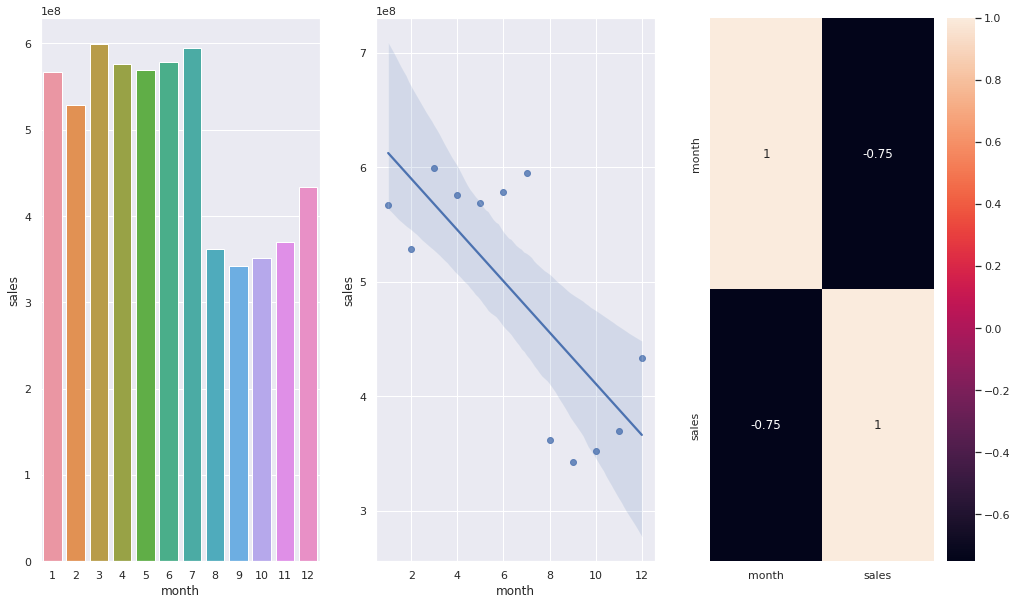

In [94]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

#tendencia
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );
#corelacao muito forte
plt.subplot( 1, 3, 3 )
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
#verdadeira: lojas vende mais depois do dia 10 de cada mes.

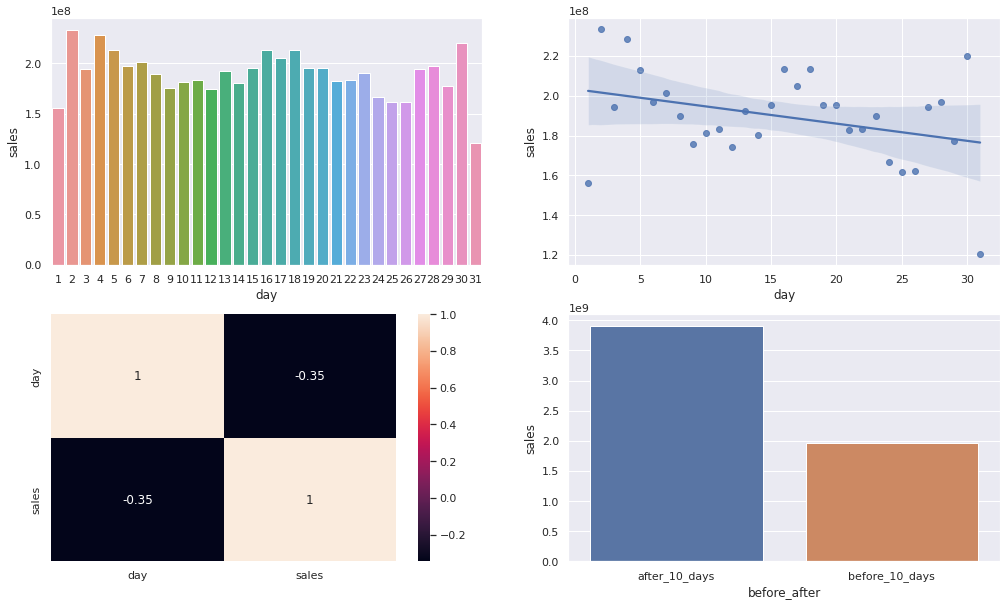

In [95]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

#tendencia
plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );
#corelacao muito forte
plt.subplot( 2, 2, 3 )
sns.heatmap (aux1.corr(method='pearson'), annot=True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after').sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );






### H11. Lojas deveriam vender menos aos finais de semana.
Verdadeira:lojas vedem menos aos finais de semana






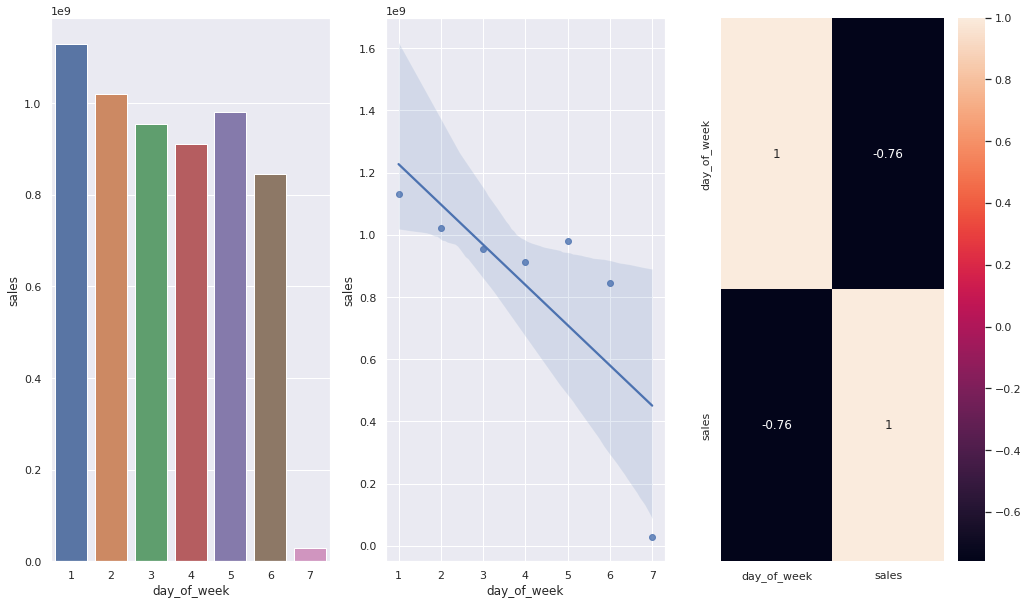

In [96]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );


plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );
#corelacao forte
plt.subplot( 1, 3, 3 )
sns.heatmap (aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender menos durante os feriados escolares.
#Verdadeira:lojas vendem menos durante os feriados escolares, exeto os mesmo de julho e agosto

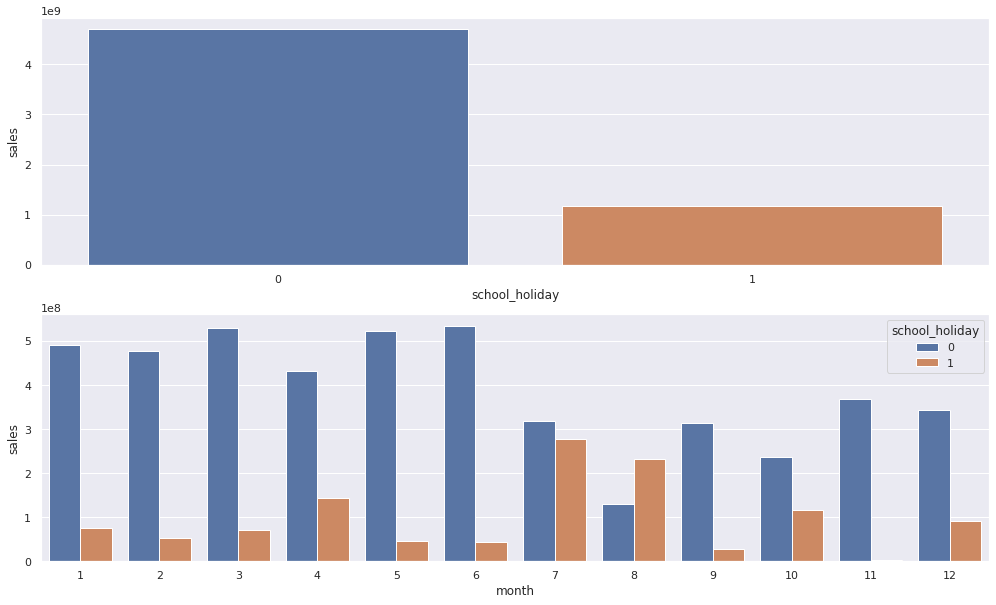

In [97]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );



### 4.2.1 Resumo Analises


In [98]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Atributes

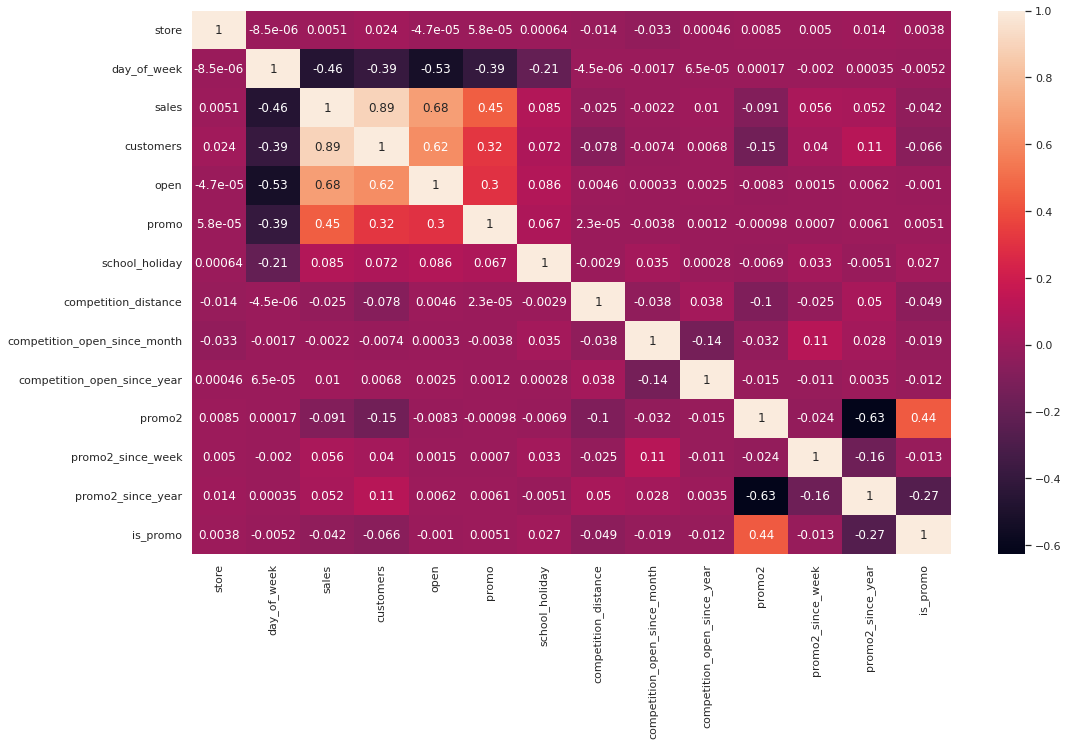

In [108]:
correlation = num_attributes.corr(method ='pearson')
sns.heatmap (correlation, annot=True);

### 4.3.2 Categorical Atributes

In [133]:
a[(a['state_holiday'] == 'christmas') & (a['store_type'] == 'a')]

,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


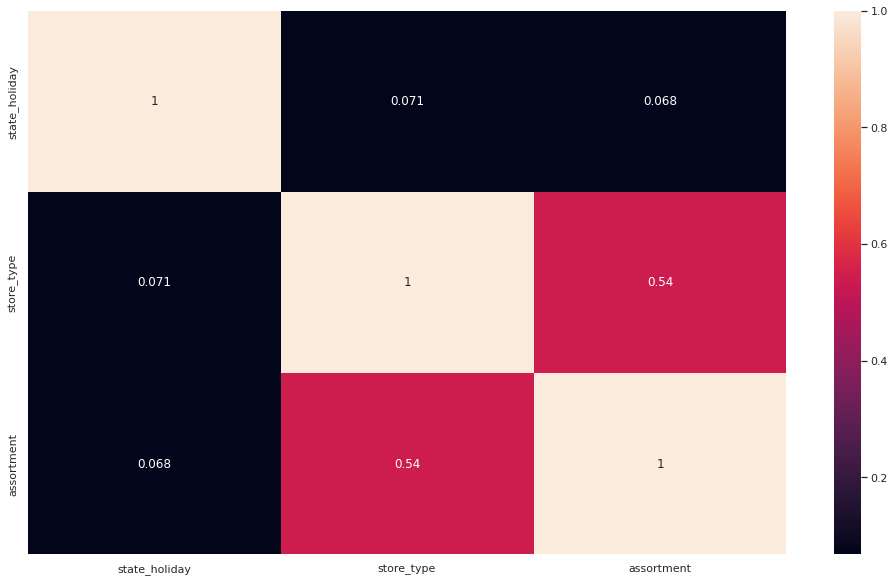

In [154]:
#only categorial data
a = df4.select_dtypes (include = 'object')

#calculate cramer
a1 = cramer_v (a['state_holiday'], a ['state_holiday'])
a2 = cramer_v (a['state_holiday'], a ['store_type'])
a3 = cramer_v (a['state_holiday'], a ['assortment'])

a4 = cramer_v (a['store_type'], a ['state_holiday'])
a5 = cramer_v (a['store_type'], a ['store_type'])
a6 = cramer_v (a['store_type'], a ['assortment'])

a7 = cramer_v (a['assortment'], a ['state_holiday'])
a8 = cramer_v (a['assortment'], a ['store_type'])
a9 = cramer_v (a['assortment'], a ['assortment'])

#Final dataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
             'store_type': [a4,a5,a6],
             'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)

sns.heatmap(d,annot=True);